**this code is an implementation of Conv_LSTM architecture inspired from this paper : https://arxiv.org/abs/2212.00796**

# **import Libs**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from datetime import datetime

/home/khadidja/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/khadidja/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **ConvLSTM Cell Implementation**

The `ConvLSTMCell` is a custom LSTM variant designed for **spatio-temporal data**, combining convolutional operations with LSTM gating mechanisms. Unlike standard LSTMs (e.g., `nn.LSTM`), which use fully connected layers for gate computations, this cell uses **2D convolutions** to process spatial patterns in the input. It maintains LSTM's core gates (input, forget, output, and cell candidate) but applies them spatially, making it ideal for data like images or feature maps. We didn't use PyTorch's predefined `nn.LSTM` because it lacks spatial awareness—it treats inputs as flat vectors, ignoring spatial relationships.

In [2]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        
        # Handle both tuple and integer kernel sizes
        if isinstance(kernel_size, tuple):
            self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        else:
            self.padding = kernel_size // 2

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=kernel_size,
            padding=self.padding
        )

    def forward(self, x, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([x, h_cur], dim=1)
        conv_output = self.conv(combined)
        
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

# **ConvLSTM Architecture**

The `ConvLSTM` class is a **multi-layer spatio-temporal LSTM** that stacks multiple `ConvLSTMCell` layers to process sequential data with spatial structure. It handles sequences of 2D feature maps (in our case cryptocurrency features treated as 1x1 maps) by iterating over time steps and layers, updating hidden and cell states at each step. Unlike PyTorch's `nn.LSTM`, which processes flat vectors, this implementation uses **convolutional operations** to preserve spatial relationships, making it suitable for tasks like price prediction where features have inherent structure. The multi-layer design allows for deeper feature extraction, while the hidden/cell states capture temporal dependencies across time steps.

In [3]:
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList()
        for i in range(num_layers):
            cur_input_dim = input_dim if i == 0 else hidden_dim
            self.cells.append(ConvLSTMCell(
                input_dim=cur_input_dim,
                hidden_dim=hidden_dim,
                kernel_size=kernel_size
            ))

    def forward(self, x, hidden_states=None):
        batch_size, seq_len, _, height, width = x.size()
        
        if hidden_states is None:
            hidden_states = [None] * self.num_layers
            
        layer_output_list = []
        for t in range(seq_len):
            input_tensor = x[:, t, :, :, :]
            
            for layer_idx in range(self.num_layers):
                if hidden_states[layer_idx] is None:
                    h = torch.zeros(batch_size, self.hidden_dim, height, width).to(x.device)
                    c = torch.zeros_like(h)
                else:
                    h, c = hidden_states[layer_idx]
                
                h, c = self.cells[layer_idx](input_tensor, (h, c))
                input_tensor = h
                hidden_states[layer_idx] = (h, c)
            
            layer_output_list.append(h)

        return torch.stack(layer_output_list, dim=1), hidden_states

# **Data Preprocessing**

In [4]:
class CryptoDataset(Dataset):
    def __init__(self, data, sequence_length=10):
        self.data = data
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len, 3]  # Predict 'Close' price
        return torch.FloatTensor(x), torch.FloatTensor([y])

# Load and preprocess data
df = pd.read_csv('../artifacts/crypto_data.csv')
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote_Asset_Volume']
close_index = features.index('Close')

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Split data
# Reverse the data to get oldest-first order
scaled_data = np.flipud(scaled_data)
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.15)
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+val_size]
test_data = scaled_data[train_size+val_size:]

# **Model Architecture**

<img src="../Time_series_models/public/Screenshot from 2025-03-06 01-09-14.png" alt="My Image" width="800"/>


In [5]:
class CryptoPredictor(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, kernel_size=3):
        super().__init__()
        self.conv_lstm = ConvLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            kernel_size=(1, kernel_size),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        # Add dummy spatial dimensions (channels=1, height=1)
        x = x.view(batch_size, seq_len, 1, 1, -1).permute(0, 1, 4, 2, 3)
        outputs, _ = self.conv_lstm(x)
        last_output = outputs[:, -1, :, :, :]
        return self.fc(last_output.squeeze())

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('test_loss', loss)    

    def configure_optimizers(self):
        return optim.NAdam(self.parameters(), lr=0.001)

# **Training**

In [6]:
seq_length = 10
batch_size = 32

# Create a contiguous copy of the data to avoid negative stride issues
train_data_copy = train_data.copy()
val_data_copy = val_data.copy()
test_data_copy = test_data.copy()

train_dataset = CryptoDataset(train_data_copy, seq_length)
val_dataset = CryptoDataset(val_data_copy, seq_length)
test_dataset = CryptoDataset(test_data_copy, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = CryptoPredictor(input_dim=len(features))
trainer = pl.Trainer(max_epochs=20, accelerator='auto')
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-03-06 01:19:32.098594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 01:19:32.107139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741220372.123162   11438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741220372.126991   11438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 01:19:32.139386: I te

/home/khadidja/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/khadidja/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1:   1%|          | 9/1435 [00:00<00:27, 51.96it/s, v_num=13]   

/home/khadidja/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19: 100%|██████████| 1435/1435 [00:33<00:00, 43.45it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1435/1435 [00:33<00:00, 43.39it/s, v_num=13]


# **Testing**

In [7]:
trainer.test(model, test_loader)

/home/khadidja/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 308/308 [00:02<00:00, 141.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0009170417324639857   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0009170417324639857}]

# **Plotting**

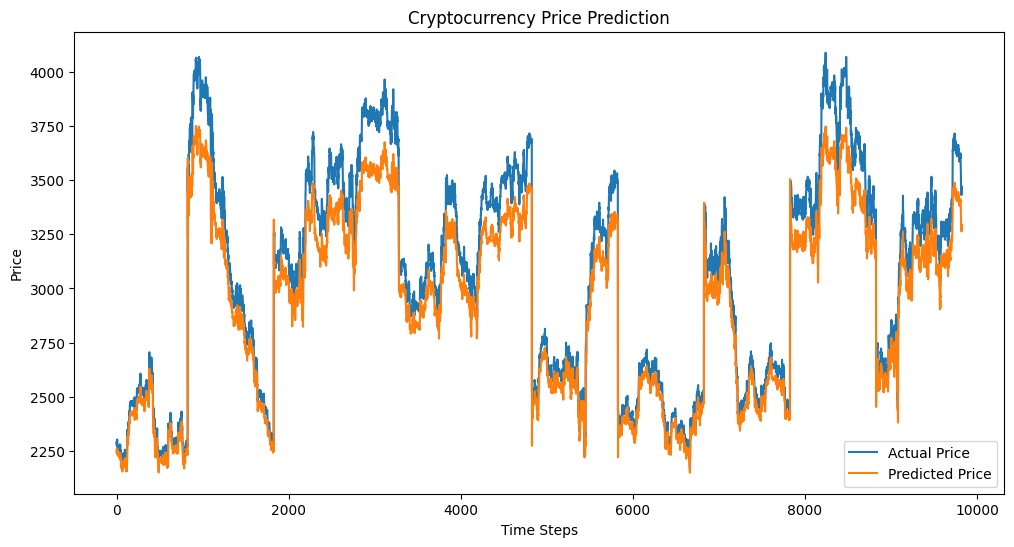

In [8]:
def plot_results(model, loader, scaler, close_idx):
    model.eval()
    preds, truths = [], []
    
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            preds.extend(pred.numpy().flatten())
            truths.extend(y.numpy().flatten())
    
    # Inverse scaling
    close_min = scaler.data_min_[close_idx]
    close_max = scaler.data_max_[close_idx]
    
    preds = np.array(preds) * (close_max - close_min) + close_min
    truths = np.array(truths) * (close_max - close_min) + close_min
    
    plt.figure(figsize=(12, 6))
    plt.plot(truths, label='Actual Price')
    plt.plot(preds, label='Predicted Price')
    plt.title('Cryptocurrency Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_results(model, test_loader, scaler, close_index)